# Modelado

In [156]:
# Supresión de advertencias para evitar ruido en la consola
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Bibliotecas de Machine Learning ---
# Modelos clásicos
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Modelos avanzados
import xgboost as xgb
from catboost import CatBoostClassifier

# --- Evaluación de Modelos ---
from sklearn.metrics import (
    precision_recall_curve, PrecisionRecallDisplay,
    average_precision_score, classification_report,
    accuracy_score, mean_squared_error, r2_score, mean_absolute_error, f1_score
)

# --- Manipulación de Datos ---
import pandas as pd  # Para manipulación de datasets
import numpy as np  # Para cálculos numéricos rápidos

# --- Reducción de Dimensionalidad ---
from sklearn.decomposition import PCA

# --- Búsqueda de Hiperparámetros y Validación ---
from sklearn.model_selection import GridSearchCV, train_test_split

# --- Pipelines ---
from sklearn.pipeline import Pipeline

# --- Deep Learning ---
from keras import models, optimizers, callbacks
from keras import layers
from keras import Sequential
from keras.utils import to_categorical
import keras_tuner as kt

# --- Serialización y Guardado de Modelos ---
import joblib

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuración Opcional para Visualización ---
# Configura visualizaciones más atractivas con Seaborn
sns.set_theme(style="whitegrid", context="notebook")

# --- Configuración General ---
# Asegúrate de establecer semillas para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- Mejora Opcional: Función para Configuración de Gráficos ---
def configurar_graficos():
    """Configura parámetros globales para gráficos."""
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.rcParams["axes.titlesize"] = 14
    plt.rcParams["axes.labelsize"] = 12
    plt.rcParams["xtick.labelsize"] = 10
    plt.rcParams["ytick.labelsize"] = 10
    plt.rcParams["legend.fontsize"] = 10
    plt.rcParams["grid.alpha"] = 0.7

# Llama a la configuración de gráficos al inicio
configurar_graficos()

# --- Mejora Opcional: Función para Supresión de Advertencias ---
def suprimir_advertencias():
    """Suprime advertencias irrelevantes para una consola limpia."""
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

# Activa la supresión de advertencias al inicio
suprimir_advertencias()

## Funciones para entrenamiento y testeo

In [94]:
def train_test_val_split(X_df:pd.DataFrame, y_df:pd.DataFrame):
    '''
    Divide la variable target y las variables features en testeo y prueba.

    Params:
    X_df (pandas.DataFrame): DataFrame con las variables features.
    y_df (pandas.DataFrame): DataFrame con la variable target.

    Returns:
    X_train (pandas.DataFrame): 80% de los datos de las variables features para entrenamiento del modelo.
    X_test (pandas.DataFrame): 10% de los datos de las variables features para testear el modelo.
    X_val (pandas.DataFrame): 10% de los datos de las variables features para validar el modelo.
    y_train (pandas.DataFrame): 80% de los datos de la variable target para entrenamiento del modelo.
    y_test (pandas.DataFrame): 10% de los datos de la variable target para testear el modelo.
    y_val (pandas.DataFrame): 10% de los datos de la variable target para validar el modelo.
    '''
    # Divido las variable target y el resto de variables en testeo y prueba 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    # Divido las variable target y el resto de variables en los conjuntos de prueba en dos subconjuntos
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [95]:
def grid_search_function(model, param_grid, X_train, y_train, pca_components=[0.50, 0.99], cv=2):
    """
    Realiza una búsqueda en cuadrícula (grid search) con validación cruzada
    para encontrar los mejores parámetros de un modelo de aprendizaje automático.

    Parámetros:
    - model: El modelo de aprendizaje automático a utilizar.
    - param_grid (dict): Diccionario de parámetros a probar en la búsqueda en cuadrícula.
    - X_train (array-like): Datos de entrenamiento.
    - y_train (array-like): Etiquetas de entrenamiento.
    - pca_components (list, opcional): Lista de componentes principales (PCA) a probar.
      Predeterminado: [0.50, 0.99]
    - cv (int, opcional): Número de divisiones para la validación cruzada. Predeterminado: 2.

    Retorna:
    tuple: Una tupla que contiene los mejores parámetros, la mejor puntuación,
    el mejor estimador y los resultados de la validación cruzada.
    """
    # Configura el pipeline con las funciones de PCA y el modelo de aprendizaje automático
    pipeline = Pipeline([
        ('pca', PCA()),
        ('classify', model)
    ])

    # Realiza la búsqueda en cuadrícula con validación cruzada utilizando el pipeline anterior
    # y los parámetros del modelo específico
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Obtiene los mejores parámetros del modelo específico
    best_params = grid_search.best_params_

    # Elimina el prefijo 'classify__' de todas las claves
    best_params = {key.replace('classify__', '', 1): value for key, value in best_params.items()}

    return best_params

In [96]:
def train(model, best_params=None):
    """
    Entrena un modelo de aprendizaje automático, opcionalmente utilizando los mejores
    parámetros obtenidos de una búsqueda en cuadrícula (grid search).

    Parámetros:
    - model: El modelo de aprendizaje automático a entrenar.
    - best_params (dict, opcional): Diccionario con los mejores parámetros para el modelo.
      Si no se proporciona, se entrenará el modelo con los parámetros predeterminados.

    Retorna:
    - El modelo entrenado.
    """
    # Si se proporcionan los mejores parámetros, se establecen en el modelo
    if best_params is not None:
        model.set_params(**best_params)

    model = model.fit(X_train, y_train)

    # Entrena el modelo con los datos de entrenamiento
    return model

In [97]:
def test(model):
    """
    Evalúa el rendimiento de un modelo de aprendizaje automático en un conjunto de prueba.
    Puede manejar tanto modelos de clasificación como de regresión.

    Parámetros:
    - model: El modelo de aprendizaje automático a evaluar.
    - is_classification (bool, opcional): Indica si el modelo es de clasificación.
      Predeterminado: False (regresión).

    Retorna:
    - y_pred: Las predicciones del modelo en el conjunto de prueba.
    """
    # Realiza las predicciones del modelo en el conjunto de prueba
    y_pred = model.predict(X_test)

    return y_pred

In [98]:
def metrics_model(y_pred: pd.DataFrame, is_classification=False, model = None):
    pred_prob = False
    
    # Si el modelo es de clasificación, calcula métricas de clasificación
    if is_classification:
        result_classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
        result_classification_report = result_classification_report[['precision', 'recall', 'f1-score']]

        # Configuración de la figura
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.5]})

        # Dibuja la curva de precisión-recall
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax1)
        ax1.set_title("2-class Precision-Recall curve")

        # Mapa de calor de métricas
        sns.barplot(result_classification_report)
        ax2.set_title('Comparativa entre metricas de rendimiento')

        plt.tight_layout()
        plt.show()

        return result_classification_report

    # Si el modelo es de regresión, calcula métricas de regresión
    else:
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        result_regression_report = {
            'Mean Absolute Error (MAE)': mae,
            'Mean Squared Error (MSE)': mse,
            'Root Mean Squared Error (RMSE)': rmse,
            'R² Score': r2
        }
        
        pprint.pprint(result_regression_report)
        
        return result_regression_report

In [99]:
def build_model(hp):
    model = Sequential()
    # Añadimos una capa de entrada con el tamaño del input_shape definido en el dataset
    model.add(layers.Input(shape=(input_shape,)))
    
    # Selecciona el número de capas ocultas (1 a 3)
    for i in range(hp.Int('num_layers', 1, 3)):
        # Tamaño de la capa oculta (32 a 512, potencias de 2)
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh', 'leaky_relu'])
        ))
        # Posible dropout para regularización
        if hp.Boolean(f'use_dropout_{i}'):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)))
    
    # Capa de salida (1 unidad para regresión, num_classes para clasificación)
    if task == "regression":
        model.add(layers.Dense(1, activation='linear'))
        loss = 'mse'
        metrics = ['mae']
    elif task == "classification":
        model.add(layers.Dense(num_classes, activation='sigmoid'))
        loss = 'binary_crossentropy'
        metrics = ['accuracy', 'Precision']

    # Compilación del modelo
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.009, 0.09, 0.9])
        ),
        loss=loss,
        metrics=metrics
    )
    
    return model

### Importacion de datos

In [100]:
path_df_estandarizado_escalado = '../data/silver/df_estandarizado_escalado.csv'
df_estandarizado_escalado = pd.read_csv(path_df_estandarizado_escalado)

In [101]:
df_estandarizado_escalado = df_estandarizado_escalado.sample(frac=1, random_state=12)

In [102]:
# Encuentra el número de registros de la clase mínima
clase_minima = df_estandarizado_escalado['subscribed_encoded'].value_counts().min()

# Toma una muestra balanceada de cada clase
clase_0 = df_estandarizado_escalado[df_estandarizado_escalado['subscribed_encoded'] == 0.0].sample(n=clase_minima, random_state=42)
clase_1 = df_estandarizado_escalado[df_estandarizado_escalado['subscribed_encoded'] == 1.0].sample(n=clase_minima, random_state=42)

# Une ambas clases en un nuevo DataFrame balanceado
df_estandarizado_escalado = pd.concat([clase_0, clase_1]).reset_index(drop=True)

### Separacion de datos

In [103]:
# separo las las variables de la variable target
X = df_estandarizado_escalado.drop(columns=['subscribed_encoded'])
y = df_estandarizado_escalado['subscribed_encoded'].astype(int)

In [104]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X_df=X, y_df=y)

### Instancia y evaluacion de modelos

#### Bagging

**Modelo 1: Bosques aleatorios:**

In [105]:
# creo instancia del modelo random forest
random_forest_model = RandomForestClassifier()

# Parametros y rango de valores para el modelo de random forest
random_forest_params_grid = {
    'classify__max_depth': [None, 5, 10],
    'classify__min_samples_split': [2, 5, 10],
    'classify__min_samples_leaf': [1, 2, 4],
    'classify__ccp_alpha': [0.0, 0.1, 0.2]
}

In [106]:
# obtengo los mejores parametros desde grid search
random_forest_best_params_grid = grid_search_function(model= random_forest_model, param_grid=random_forest_params_grid, X_train=X_train, y_train=y_train)

In [107]:
# entreno el modelo con los mejores parametros previamente obtenidos
random_forest_model = train(random_forest_model, random_forest_best_params_grid)

In [108]:
# obtengo las predicciones del modelo
y_pred = test(random_forest_model)

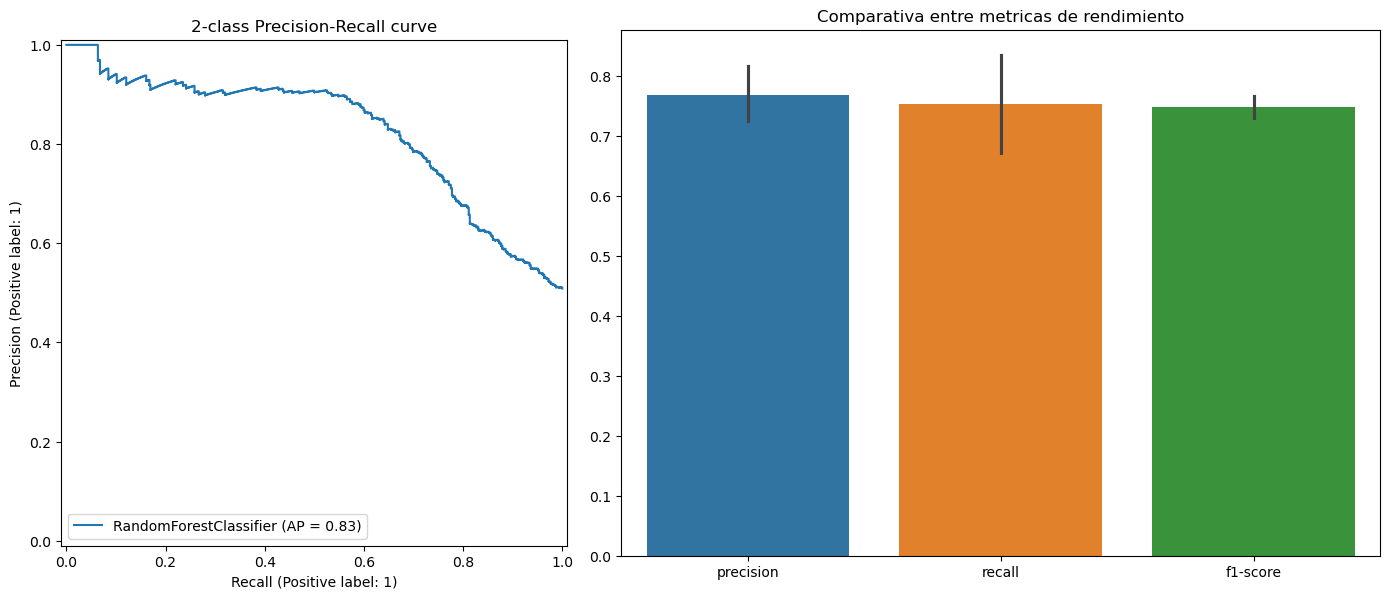

,precision,recall,f1-score
0,0.691652,0.890351,0.778523
1,0.853372,0.616525,0.715867
accuracy,0.751078,0.751078,0.751078
macro avg,0.772512,0.753438,0.747195
weighted avg,0.773907,0.751078,0.746655


In [109]:
metrics_model(y_pred, is_classification=True, model=random_forest_model)

**Modelo 2: Extra Trees**

In [110]:
# instancia del modelo extratrees
extra_trees_model = ExtraTreesClassifier()

# Define los parámetros a optimizar
extra_trees_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__max_depth': [None, 10, 20],
    'classify__min_samples_split': [2, 5],
    'classify__min_samples_leaf': [1, 2],
    'classify__max_features': ['auto', 'sqrt'],
    'classify__bootstrap': [False, True]
}

In [111]:
extra_trees_best_params_grid = grid_search_function(model= extra_trees_model, param_grid=extra_trees_params_grid, X_train=X_train, y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cristianariel/miniconda3/lib/python3.12/site-pack

In [112]:
extra_trees_model = train(model=extra_trees_model, best_params=extra_trees_best_params_grid)

In [113]:
y_pred = test(model=extra_trees_model)

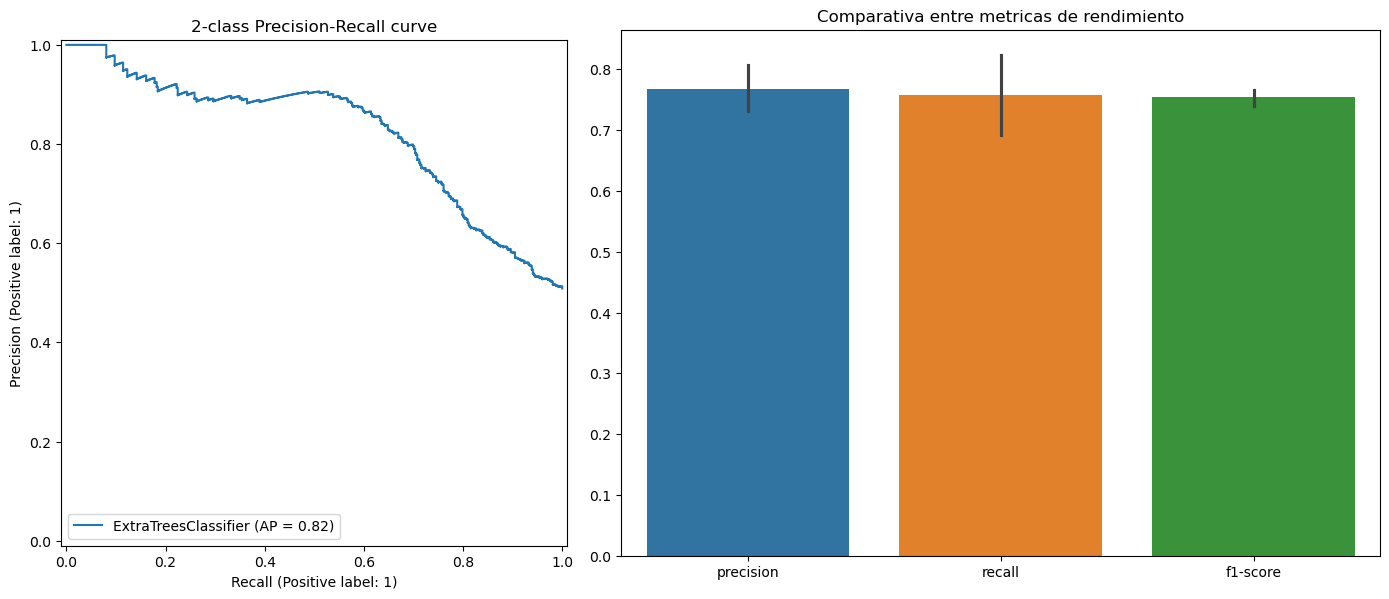

,precision,recall,f1-score
0,0.704626,0.868421,0.777996
1,0.836066,0.648305,0.730310
accuracy,0.756466,0.756466,0.756466
macro avg,0.770346,0.758363,0.754153
weighted avg,0.771479,0.756466,0.753742


In [114]:
metrics_model(y_pred, is_classification=True, model=extra_trees_model)

#### Boosting

**Modelo 1: AdaBoost**

In [115]:
# Define el modelo base y el modelo AdaBoost
base_estimator = DecisionTreeClassifier()
AdaBoostClassifier_model = AdaBoostClassifier(estimator=base_estimator)

# Define los parámetros a optimizar
ada_boost_params_grid = {
    'classify__n_estimators': [50, 100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'classify__estimator__max_depth': [1, 2, 3],
    'classify__algorithm': ['SAMME', 'SAMME.R']
}

In [116]:
ada_boost_best_params_grid = grid_search_function(model=AdaBoostClassifier_model, param_grid=ada_boost_params_grid, X_train=X_train,y_train=y_train)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

In [117]:
AdaBoostClassifier_model = train(model=AdaBoostClassifier_model, best_params=ada_boost_best_params_grid)

/Users/cristianariel/miniconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [118]:
y_pred = test(model=AdaBoostClassifier_model)

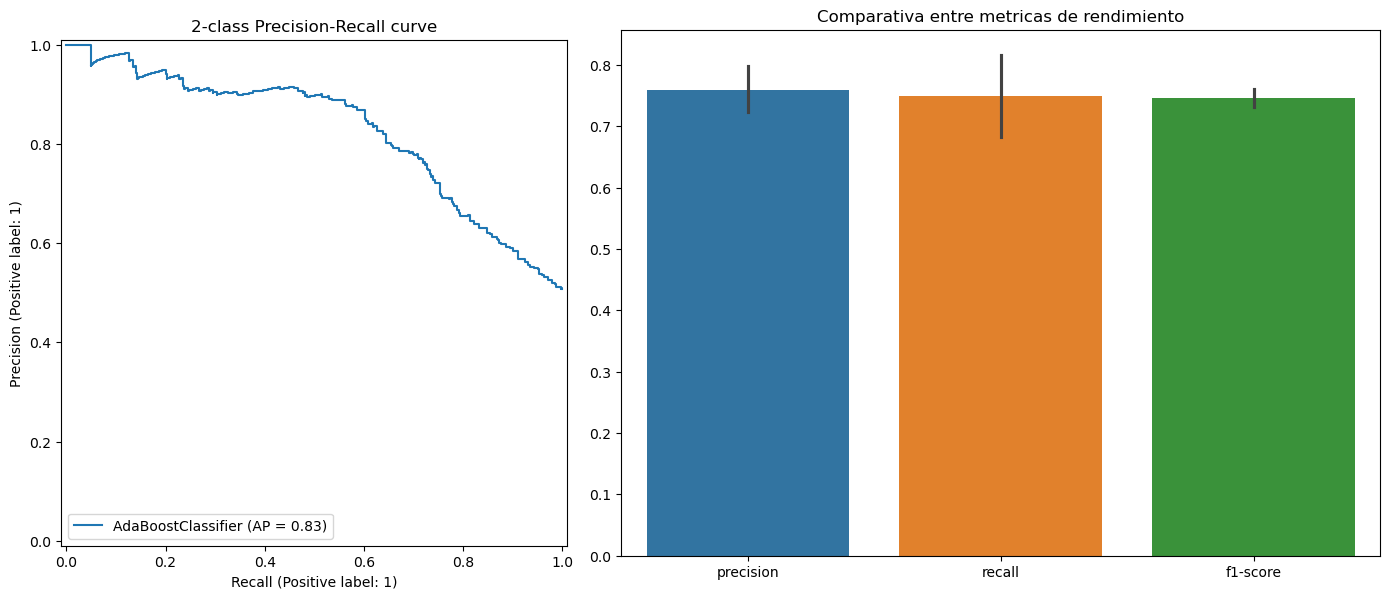

,precision,recall,f1-score
0,0.696809,0.861842,0.770588
1,0.826923,0.637712,0.720096
accuracy,0.747845,0.747845,0.747845
macro avg,0.761866,0.749777,0.745342
weighted avg,0.762987,0.747845,0.744907


In [119]:
metrics_model(y_pred, is_classification=True, model=AdaBoostClassifier_model)

**Modelo 2: XGBoost**


In [120]:
# Definir el modelo
xgb_model = xgb.XGBClassifier()

# Definir el grid de parámetros
xgb_params_grid = {
    'classify__n_estimators': [100, 200],
    'classify__learning_rate': [0.01, 0.1, 0.2],
    'classify__max_depth': [3, 5, 7],
    'classify__subsample': [0.8, 1.0],
    'classify__colsample_bytree': [0.8, 1.0]
}

In [121]:
xgb_best_params_grid = grid_search_function(model= xgb_model, param_grid=xgb_params_grid, X_train=X_train, y_train=y_train)

In [122]:
xgb_model = train(model=xgb_model, best_params=xgb_best_params_grid)

In [123]:
y_pred = test(model=extra_trees_model)

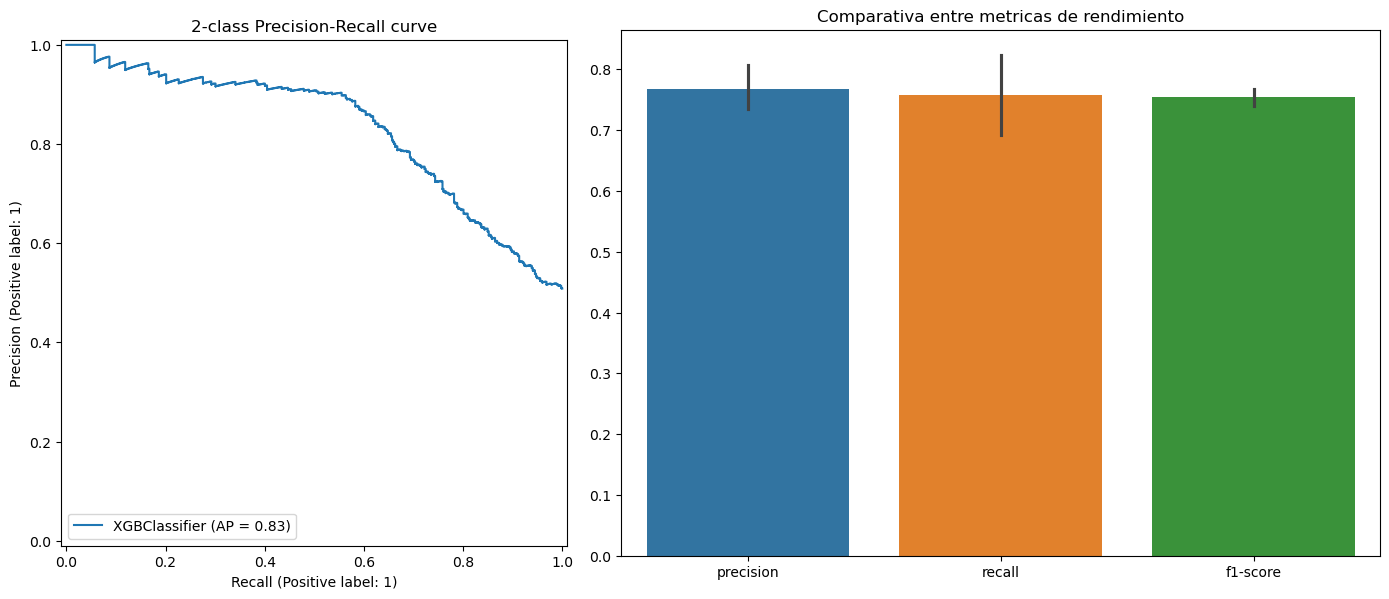

,precision,recall,f1-score
0,0.704626,0.868421,0.777996
1,0.836066,0.648305,0.730310
accuracy,0.756466,0.756466,0.756466
macro avg,0.770346,0.758363,0.754153
weighted avg,0.771479,0.756466,0.753742


In [124]:
metrics_model(y_pred, is_classification=True, model= xgb_model)

**Modelo 3: Stochastic Gradient Boosting**

In [127]:
# Definir el modelo
sgb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de parámetros
sgb_params_grid = {
    'classify__learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje.
    'classify__n_estimators': [100, 200, 300],  # Número de etapas de refuerzo.
    'classify__max_depth': [3, 5, 7],  # Profundidad máxima de los árboles.
    'classify__subsample': [0.6, 0.8, 1.0],  # Fracción de datos usados en cada iteración.
    'classify__min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir un nodo.
    'classify__min_samples_leaf': [1, 2, 5],  # Mínimo de muestras por hoja.
    'classify__max_features': ['sqrt', 'log2', None],  # Número máximo de características.
    'classify__random_state': [42],  # Semilla para reproducibilidad.
}

In [ ]:
sgb_best_params_grid = grid_search_function(model= sgb_model, param_grid=sgb_params_grid, X_train=X_train, y_train=y_train)

In [ ]:
sgb_model = train(model=sgb_model, best_params=xgb_best_params_grid)

In [ ]:
y_pred = test(model=extra_trees_model)

In [ ]:
metrics_model(y_pred, is_classification=True, model=sgb_model)

#### Vooting

**Modelo 2: Soft Voting**

In [133]:
voting_clf_soft_model = VotingClassifier(estimators=[('rf', random_forest_model), ('xgb', xgb_model)],
                              voting='soft',
                              weights=[1, 1]) 

In [134]:
voting_clf_soft_model = train(model= voting_clf_soft_model)

In [135]:
y_pred = test(model=voting_clf_soft_model)

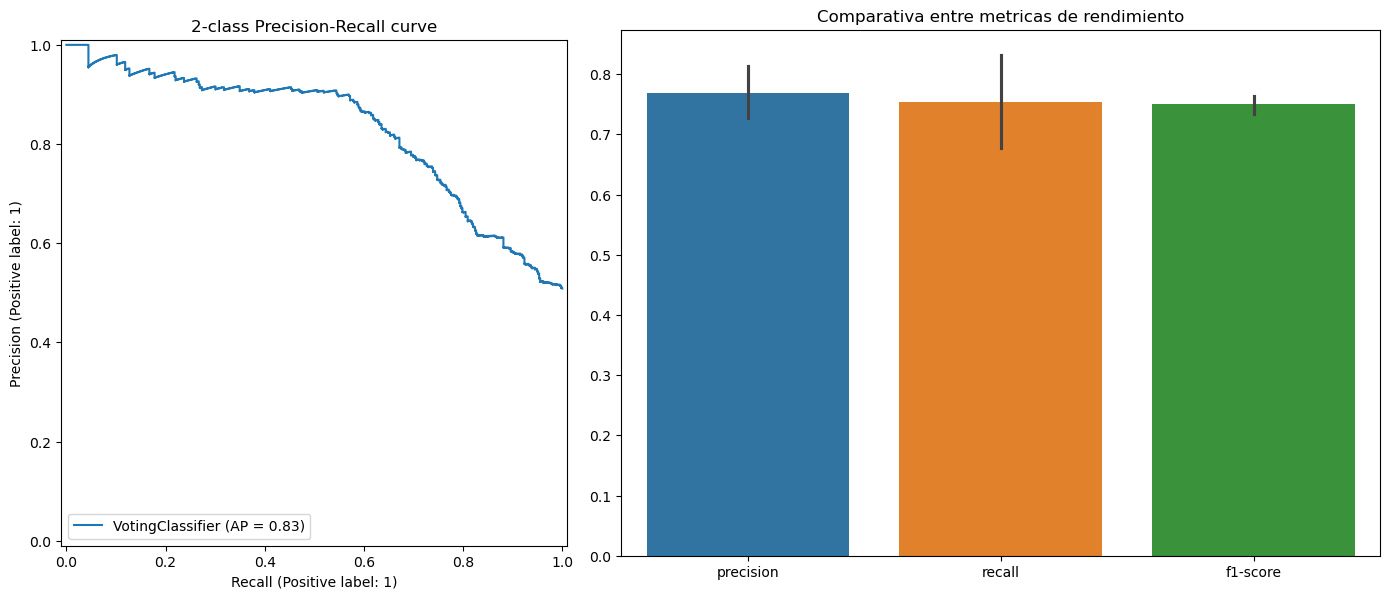

,precision,recall,f1-score
0,0.696028,0.883772,0.778744
1,0.848138,0.627119,0.721072
accuracy,0.753233,0.753233,0.753233
macro avg,0.772083,0.755445,0.749908
weighted avg,0.773394,0.753233,0.749411


In [136]:
metrics_model(y_pred, is_classification=True, model= voting_clf_soft_model)

### Deep learning

#### DNN

*Construccion de la RNA*

In [151]:
# Configura el hiperparámetro de entrada
input_shape = X_train.shape[1]  # Cambia esto al número de características en tu dataset
task = "classification"  # O usa "regression" si tu tarea es de regresión
num_classes = 1  # Cambia esto al número de clases (para clasificación)

# Define el tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy' if task == "classification" else 'val_mae',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='keras_tuner_demo'
)

# Callback para early stopping
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Realiza la búsqueda de hiperparámetros
tuner.search(X_train, 
            y_train, 
            epochs=16, 
            validation_data=(X_val, y_val), 
            callbacks=[stop_early],
            batch_size=32)

# Obtén los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Mejores hiperparámetros:
Número de capas ocultas: {best_hps.get('num_layers')}
Activación: {best_hps.get('activation')}
Unidades por capa: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
Dropout: {[best_hps.get(f'use_dropout_{i}') for i in range(best_hps.get('num_layers'))]}
Learning rate: {best_hps.get('learning_rate')}
""")

# Construye el modelo con los mejores hiperparámetros
best_model = tuner.hypermodel.build(best_hps)

# Entrena el modelo con los mejores hiperparámetros
best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Reloading Tuner from my_dir/keras_tuner_demo/tuner0.json

Mejores hiperparámetros:
Número de capas ocultas: 2
Activación: leaky_relu
Unidades por capa: [128, 32]
Dropout: [False, False]
Learning rate: 0.009

Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Precision: 0.6577 - accuracy: 0.6581 - loss: 0.6556 - val_Precision: 0.7690 - val_accuracy: 0.7144 - val_loss: 0.5868
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - Precision: 0.7575 - accuracy: 0.7229 - loss: 0.5584 - val_Precision: 0.7506 - val_accuracy: 0.7188 - val_loss: 0.5609
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - Precision: 0.7796 - accuracy: 0.7235 - loss: 0.5536 - val_Precision: 0.8605 - val_accuracy: 0.7274 - val_loss: 0.5790
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - Precision: 0.7974 - accuracy: 0.7381 - loss: 0.5456 - val_Precision: 0.7916 - val_accuracy: 0.7317 - val_loss: 0.5555
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - Precision: 0.7806 - accuracy: 0.7362 - los

*Predicción con el subconjunto de datos de pruebas*

In [152]:
error, accuracy, precision = best_model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - Precision: 0.8048 - accuracy: 0.7620 - loss: 0.5160


In [153]:
y_pred = best_model.predict(X_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


In [154]:
y_pred = (y_pred > 0.5).astype(int)

In [157]:
f1_score(y_test, y_pred)

0.7397260273972602

In [158]:
print("Error: ", error)
print("Accuracy: ", accuracy)
print("Precision: ", precision)

Error:  0.5195212960243225
Accuracy:  0.7543103694915771
Precision:  0.801980197429657


### Guardado del mejor modelo

In [160]:
# Guardar el modelo entrenado en un archivo .pkl
path_best_ml_model = '../models/xgb_model.pkl'
joblib.dump(xgb_model, path_best_ml_model)

['../models/xgb_model.pkl']

### Observaciones de esta etapa:
Respecto a la prediccion de la variable target "subscribed", el modelo con mayor f1 es un modelo de ensamble tipo Boosting, espesificamente **XGBoost con un f1 Scores del 77.79%**.